# Branch & Bound and Knapsack Lab

**Objectives**
- Preform the branch and bound algorithm
- Apply branch and bound to the knapsack problem
- Understand the geometry of the branch and bound algorithm

**Brief description:** In this lab, we will try solving an example of a knapsack problem with the branch-and-bound algorithm. We will also see how adding a cutting plane helps in reducing the computation time and effort of the algorithm. Lastly, we will explore the geometry of the branch and bound algorithm.

In [31]:
# imports -- don't forget to run this cell
import pandas as pd
import gilp
from gilp.visualize import feasible_integer_pts
from ortools.linear_solver import pywraplp as OR

## Part 1: Branch and Bound Algorithm

Recall that the branch and bound algorithm (in addition to the simplex method) allows us to solve integer programs. Before applying the branch and bound algorithm to the knapsack problem, we will begin by reviewing some core ideas. Furthermore, we will identify a helpful property that will make branch and bound terminate quicker later in the lab!

**Q1:** What are the different ways a node can be fathomed during the branch and bound algorithm? Describe each.

**A:**  A node can be fathomed if the LP solution is also an IP solution. A node can also be fathomed if the LP solution is less optimal than an IP solution found in another node.

**Q2:** Suppose you have a maximization integer program and you solve its linear program relaxation. What does the LP-relaxation optimal value tell you about the IP optimal value? What if it is a minimization problem?

**A:** The LP solution tells you that the IP optimal value is less than or equal to the LP optimal value in a maximization problem. 

The LP solution tells you that the IP optimal value is greater than or equal to the LP optimal value in a minimization problem. 

**Q3:** Assume you have a maximization integer program with all integral coefficents in the objective function. Now, suppose you are running the branch and bound algorithm and come across a node with an optimal value of 44.5. The current incumbent is 44. Can you fathom this node? Why or why not?

**A:** Yes as it is the best integer solution.

**Q4:** If the optimal solution to the LP relaxation of the original program is integer, then you have found an optimal solution to your integer program. Explain why this is true.

**A:** Because then that is also an IP solution and we know to fathom a node if the LP solution is also an IP solution.

**Q5:** If the LP is infeasible, then the IP is infeasible. Explain why this is true.

**A:** Well if the LP is infeasible, there will be no case in which any solution to the Ip is feasible because LP is more specific in every case than the LP so no IP feasible solution is outside the area of the LP feasible solution area.

The next questions ask about the following branch and bound tree. If the solution was not integral, the fractional $x_i$ that was used to branch is given. If the solution was integral, it is denoted *INT*. In the current iteration of branch and bound, you are looking at the node with the *****.

<img src="part1_bnb_tree.png" width="500"/>

**Q6:** Can you determine if the integer program this branch and bound tree is for is a minimization or maximixation problem? If so, which is it?

**A:** It is a minimization problem.

Hint: For **Q7-8**, you can assume integral coefficents in the objective function.

**Q7:** Is the current node (marked $z^*$) fathomed? Why or why not? If not, what additional constraints should be imposed for each of the next two nodes?

**A:** Not fathomed. For the next 2 connecting nodes, one will have a constraint of 0<=x1 and the other will havea constraint of x1<=1.

**Q8:** Consider the nodes under the current node (where $z = 16.3$). What do you know about the optimal value of these nodes? Why? 

**A:** The optimal value of all nodes under that node must be at least 16.3.

## Part 2: The Knapsack Problem

In this lab, you will solve an integer program by branch and bound. The integer program to be solved will be a knapsack problem.

**Knapsack Problem:** We are given a collection of $n$ items, where each item $i = 1,\dots,n$ has a weight $w_i$ and a value $v_i$. In addition, there is a given capacity $W$, and the aim is to select a maximum value subset of items that has a total weight at most $W$. Note that each item can be brought at most once.

$$\begin{align*}
\max \quad & \sum_{i=1}^n v_ix_i\\
\text{s.t.} \quad & \sum_{i=1}^n w_ix_i \leq W \\
& 0 \leq x_i \leq 1, \text{integer}, i = 1,\dots,n
\end{align*}$$

Consider the following data which we import from a CSV file:

In [32]:
data = pd.read_csv('knapsack_data_1.csv', index_col=0)
data

,value,weight
item,,
1,50,10
2,30,12
3,24,10
4,14,7
5,12,6
6,10,7
7,40,30


and $W = 18$. 

**Q9:** Are there any items we can remove from our input to simplify this problem? Why? If so, replace `index` with the item number that can be removed in the code below. Hint: how many of each item could we possibly take?

**A:** We can remove 7 because you cannot take any integer values of 7 under any circumstances.

In [33]:
# TODO: replace index
data = data.drop(7)

**Q10:** If we remove item 7 from the knapsack, it does not change the optimal solution to the integer program. Explain why.

**A:** As the weight of 7 alone is more than the weight allowed, it would never have been able to be selected in an integer program anyways, so it would not change the optimal solution to the IP.

**Q11:** Consider removing items $i$ such that $w_i > W$ from a knapsack input. How does the LP relaxation's optimal value change?

**A:** The LP relaxation's optimal value should not change at all.

In **Q10-11**, you should have found that removing these items removes feasible solutions from the linear program  but does not change the integer program. This is desirable as the gap between the optimal IP and LP values can become smaller. By adding this step, branch and bound may terminate sooner. 

Recall that a branch and bound node can be fathomed if its bound is no better than the value of the best feasible integer solution found thus far. Hence, it helps to have a good feasible integer solution as quickly as possible (so that we stop needless work). To do this, we can first try to construct a good feasible integer solution by a reasonable heuristic algorithm before starting to run the branch and bound procedure.

In designing a heuristic for the knapsack problem, it is helpful to think about the value per unit weight for each item. We compute this value in the table below.

In [34]:
data['value per unit weight'] = (data['value'] / data['weight']).round(2)
data

,value,weight,value per unit weight
item,,,
1,50,10,5.00
2,30,12,2.50
3,24,10,2.40
4,14,7,2.00
5,12,6,2.00
6,10,7,1.43


**Q12:** Design a reasonable heuristic for the knapsack problem. Note a heuristic aims to find a decent solution to the problem (but is not necessarily optimal).

**A:** Add as many of the highest value to weight ratio item as you can and then attempt to add the second highest value to weight ratio item. If that goes over weight, try the third highest ratio item and so on.

**Q13:** Run your heuristic on the data above to compute a good feasible integer solution. Your heuristic should generate a feasible solution with a value of 64 or better. If it does not, try a different heuristic (or talk to your TA!)

**A:** W=18. So, we can take one of item 1, nd then we try item 2. Item 2 is overweight so we try item 3. Item 3 would put us overweight so we try item 4. We can add item 4 so now we have a weight of 17 and a value of 64.

We will now use the branch and bound algorithm to solve this knapsack problem! First, let us define a mathematical model for the linear relaxation of the knapsack problem.

**Q14:** Complete the model below.

In [35]:
def Knapsack(table, capacity, integer = False):
    """Model for solving the Knapsack problem.
    
    Args:
        table (pd.DataFrame): A table indexd by items with a column for value and weight
        capcity (int): An integer-capacity for the knapsack
        integer (bool): True if the variables should be integer. False otherwise.
    """
    ITEMS = list(table.index)        # set of items
    v = table.to_dict()['value']     # value for each item 
    w = table.to_dict()['weight']    # weight for each item
    W = capacity                     # capacity of the knapsack
    
    # define model
    m = OR.Solver('knapsack', OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    # decision variables
    x = {}    
    for i in ITEMS:
        if integer:
            x[i] = m.IntVar(0, 1, 'x_%d' % (i)) 
        else:
            x[i] = m.NumVar(0, 1, 'x_%d' % (i)) 
        
    # define objective function here
    m.Maximize(sum(v[i]*x[i] for i in ITEMS))
    m.Add((sum(w[i]*x[i] for i in x))<=W)
    # TODO: Add a constraint that enforces that weight must not exceed capacity
    # recall that we add constraints to the model using m.Add()
    
    return (m, x)  # return the model and the decision variables

In [36]:
# You do not need to do anything with this cell but make sure you run it!
def solve(m):
    """Used to solve a model m."""
    m.Solve()
    
    print('Objective =', m.Objective().Value())
    print('iterations :', m.iterations())
    print('branch-and-bound nodes :',m.nodes())
    
    return ({var.name() : var.solution_value() for var in m.variables()})

We can now create a linear relaxation of our knapsack problem. Now, `m` represents our model and `x` represents our decision variables.

In [37]:
m, x = Knapsack(data, 18)

We can use the next line to solve the model and output the solution

In [38]:
solve(m)

Objective = 70.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.6666666666666667,
 'x_3': 0.0,
 'x_4': 0.0,
 'x_5': 0.0,
 'x_6': 0.0}

**Q15:** How does this optimal value compare to the value you found using the heuristic integer solution?

**A:** This optimal value does not have integer inputs so it is bigger than the IP solution we obtained with the heuristic integer solution.

**Q16:** Should this node be fathomed? If not, what variable should be branched on and what additional constraints should be imposed for each of the next two nodes?


**A:** The node should be fathomed.

After constructing the linear relaxation model using `Knapsack(data1, 18)` we can add additional constraints. For example, we can add the constraint $x_2 \leq 0$ and solve it as follows:

In [39]:
m, x = Knapsack(data, 18)
m.Add(x[2] <= 0)
solve(m)

Objective = 69.2
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0, 'x_2': 0.0, 'x_3': 0.8, 'x_4': 0.0, 'x_5': 0.0, 'x_6': 0.0}

 **NOTE:** The line `m, x = Knapsack(data1, 18)` resets the model `m` to the LP relaxation. All constraints from branching have to be added each time.

**Q17:** Use the following cell to compute the optimal value for the other node you found in **Q16**.

In [40]:
m, x = Knapsack(data, 18)
m.Add(x[2] <= 0)
solve(m)

Objective = 69.2
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0, 'x_2': 0.0, 'x_3': 0.8, 'x_4': 0.0, 'x_5': 0.0, 'x_6': 0.0}

**Q18:** What was the optimal value? Can this node be fathomed? Why? (Hint: In **Q13**, you found a feasible integer solution with value 64.)

**A:** This node can be fathomed because the LP optimal solution in this node is less than the IP optimal solution in the node from Q13.

If we continue running the branch and bound algorithm, we will eventually reach the branch and bound tree below where the $z^*$ indictes the current node we are looking at.

<img src="part2_bnb_tree.png" width="700"/>

**Q19:** The node with $z = 64.857$ was fathomed. Why are we allowed to fathom this node? (Hint: think back to **Q3**)

**A:** We can fathom this node because it is better then our current best IP solution.

**Q20:** Finish running branch and bound to find the optimal integer solution. Use a separate cell for each node you solve and indicate if the node was fathomed with a comment. (Hint: Don't forget to include the constraints further up in the branch and bound tree.)

In [41]:
m, x = Knapsack(data, 18)
m.Add(x[2]<=0)
m.Add(x[3]<=0)
m.Add(x[4]>=1)
m.Add(x[5]<=0)
solve(m)
#node not fathomed

Objective = 65.42857142857143
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 1.0,
 'x_5': 0.0,
 'x_6': 0.14285714285714302}

In [42]:
m, x = Knapsack(data, 18)
m.Add(x[2]<=0)
m.Add(x[3]<=0)
m.Add(x[4]>=1)
m.Add(x[5]<=0)
m.Add(x[6]<=0)
solve(m)
#node not fathomed

Objective = 64.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0, 'x_2': 0.0, 'x_3': 0.0, 'x_4': 1.0, 'x_5': 0.0, 'x_6': 0.0}

In [43]:
m, x = Knapsack(data, 18)
m.Add(x[2]<=0)
m.Add(x[3]<=0)
m.Add(x[4]>=1)
m.Add(x[5]<=0)
m.Add(x[6]>=1)
solve(m)
#node fathomed

Objective = 44.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 0.4, 'x_2': 0.0, 'x_3': 0.0, 'x_4': 1.0, 'x_5': 0.0, 'x_6': 1.0}

**A:** 

**Q21:** How many nodes did you have to explore while running the branch and bound algorithm?

**A:** Two more nodes.

In the next section, we will think about additional constraints we can add to make running branch and bound quicker.

## Part 3: Cutting Planes

In general, a cutting plane is an additional constraint we can add to an integer program's linear relaxation that removes feasible linear solutions but does not remove any integer feasible solutions. This is very useful when  solving integer programs! Recall many of the problems we have learned in class have something we call the "integrality property". This is useful because it allows us to ignore the integrality constraint since we are garunteed to reach an integral solution. By cleverly adding cutting planes, we strive to remove feasible linear solutions (without removing any integer feasible solutions) such that the optimal solution to the linear relaxation is integral!

Conisder an integer program whose linear program releaxation is 

$$\begin{align*}
\max \quad & 2x_1+x_2\\
\text{s.t.} \quad & x_1 + x_2 \leq 3 \\
& 2x_1 \leq 5 \\
& -x_1 + 2x_2 \leq 2 \\
& x_1, x_2 \geq 0
\end{align*}$$

We can define this linear program and then visualize its feasible region. The integer points have been highlighted.

In [44]:
lp = gilp.LP([[1,1],[2,0],[-1,2]],
             [3,5,2],
             [2,1])
fig = gilp.lp_visual(lp)
fig.set_axis_limits([3.5,2])
fig.add_trace(feasible_integer_pts(lp, fig))
fig

**Q22:** List every feasible solution to the integer program.

**A:**(0,0), (1,0), (2,0), (0,1), (1,1), (1,2)

**Q23:** Is the constraint $x_2 \leq 1$ a cutting plane? Why? (Hint: Would any feasible integer points become infeasible? What about feasible linear points?)

**A:** x<=2 is a cutting plane because it takes away feasible linear points. It does not take away any feasible integer points.

Let's add this cutting plane to the LP relaxation!

In [45]:
lp = gilp.LP([[1,1],[2,0],[-1,2],[0,1]],
             [3,5,2,1],
             [2,1])
fig = gilp.lp_visual(lp)
fig.set_axis_limits([3.5,2])
fig.add_trace(feasible_integer_pts(lp, fig))
fig

**Q24:** Is the constraint $x_1 \leq 3$ a cutting plane? Why?

**A:** No becayse there is already a constraint that x1<=2.5 so this new constraint would have no effect on the feasible solution.

**Q25:** Can you provide another cutting plane? If so, what is it?

**A:** x1<=2

Let's look at the feasible region after adding the cutting plane from **Q23** and one of the possible answers from **Q25**. Notice the optimal solution to the LP relaxation is now integral!

In [46]:
lp = gilp.LP([[1,1],[2,0],[-1,2],[0,1],[1,0]],
             [3,5,2,1,2],
             [2,1])
fig = gilp.lp_visual(lp)
fig.set_axis_limits([3.5,2])
fig.add_trace(feasible_integer_pts(lp, fig))
fig

Let's try applying what we know about cutting planes to the knapsack problem! Again, recall our input was $W = 18$ and:

In [47]:
data

,value,weight,value per unit weight
item,,,
1,50,10,5.00
2,30,12,2.50
3,24,10,2.40
4,14,7,2.00
5,12,6,2.00
6,10,7,1.43


**Q26:** Look at items 1, 2, and 3. How many of these items can we take simultaneously? Can you write a new constraint to capture this? If so, please provide it.

**A:** If we are dealing with an integer input, then we can only take one of these items total. It does not matter which one but it just has to be one. A constraint could be x1+x2+x3 <= 1

**Q27:** Is the constraint you found in **Q26** a cutting plane? If so, provide a feasible solution to the linear program relaxation that is no longer feasible (i.e. a point the constraint *cuts off*).

**A:**  Yes as it severely limits the amount of linear feasible solutions.

**Q28:** Provide another cutting plane involving items 4,5 and 6 for this integer program. Explain how you derived it.

**A:** x4+x5+x6 <= 2. I found this because it does not matter which combination you have of items 4, 5, and 6, no more than 2 items total can be chosen from those three items.

**Q29:** Add the cutting planes from **Q26** and **Q28** to the model and solve it. You should get a solution in which we take items 1 and 4 and $\frac{1}{6}$ of item 5 with an objective value of 66.

In [48]:
m, x = Knapsack(data, 18)
# TODO: Add cutting planes here
m.Add((x[1]+x[2]+x[3])<=1)
m.Add((x[4]+x[5]+x[6])<=2)
solve(m)

Objective = 66.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 1.0,
 'x_5': 0.16666666666666696,
 'x_6': 0.0}

Let's take a moment to pause and reflect on what we are doing. Recall from **Q9-11** that we dropped item 7 becuase its weight was greater than the capcity of the knapsack. Essentially we added the constraint $x_7 \leq 0$. This constraint was a cutting plane! It eliminated some linear feasible solutions but no integer ones. By adding these two new cutting planes, we can get branch and bound to terminate earlier yet again! So far, we have generated cutting planes by inspection. However, there are more algorithmic ways to identify them (which we will ignore for now).

If we continue running the branch and bound algorithm, we will eventually reach the branch and bound tree below where the $z^*$ indictes the current node we are looking at. 

<img src="part3_bnb_tree.png" width="700"/>

**NOTE:** Do not forget about the feasible integer solution our heuristic gave us with value 64.

**Q30** Finish running branch and bound to find the optimal integer solution. Use a separate cell for each node you solve and indicate if the node was fathomed with a comment. Hint: Don't forget the cutting plane constraints should be included in every node of the branch and bound tree.

In [49]:
# Template
m, x = Knapsack(data, 18)
# Add constraints here
m.Add((x[1]+x[2]+x[3])<=1)
m.Add((x[4]+x[5]+x[6])<=2)
m.Add(x[5]>=1)
solve(m)
#node not fathomed

Objective = 66.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 0.28571428571428586,
 'x_5': 1.0,
 'x_6': 0.0}

In [50]:
m, x = Knapsack(data, 18)
# Add constraints here
m.Add((x[1]+x[2]+x[3])<=1)
m.Add((x[4]+x[5]+x[6])<=2)
m.Add(x[5]>=1)
m.Add(x[6]>=1)
solve(m)
#node fathomed

Objective = 47.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 0.5, 'x_2': 0.0, 'x_3': 0.0, 'x_4': 0.0, 'x_5': 1.0, 'x_6': 1.0}

In [51]:
m, x = Knapsack(data, 18)
# Add constraints here
m.Add((x[1]+x[2]+x[3])<=1)
m.Add((x[4]+x[5]+x[6])<=2)
m.Add(x[5]>=1)
m.Add(x[6]<=0)
solve(m)
#node not fathomed

Objective = 66.0
iterations : 0
branch-and-bound nodes : 0


{'x_1': 1.0,
 'x_2': 0.0,
 'x_3': 0.0,
 'x_4': 0.28571428571428586,
 'x_5': 1.0,
 'x_6': 0.0}

**A:** 

**Q31:** Did you find the same optimal solution? How many nodes did you explore? How did this compare to the number you explored previously?

**A:** Yes, the optimal solution was 47. I expolored two extra nodes. This is equivalent to the number of nodes that I explored in Part 2.

## Part 4: Geometry of Branch and Bound

Previously, we used the `gilp` package to viusualize the simplex algorithm but it also has the functionality to visualize branch and bound. We will give a quick overview of the tool. Similar to `lp_visual` and `simplex_visual`, the function `bnb_visual` takes an `LP` and returns a visualization. It is assumed that every decision variable is constrained to be integer. Unlike previous visualizations, `bnb_visual` returns a series of figures for each node of the branch and bound tree. Let's look at a small 2D example:

$$\begin{align*}
\max \quad & 5x_1+ 8x_2\\
\text{s.t.} \quad & x_1 + x_2 \leq 6 \\
& 5x_1 + 9x_2 \leq 45 \\
& x_1, x_2 \geq 0, \quad \text{integral}
\end{align*}$$

In [52]:
nodes = gilp.bnb_visual(gilp.examples.STANDARD_2D_IP)

In [53]:
nodes[0].show()

Run the cells above to generate a figure for each node and view the first node. At first, you will see the LP relaxation on the left and the root of the branch and bound tree on the right. The simplex path and isoprofit slider are also present.

**Q32:** Recall the root of a branch and bound tree is the unaltered LP relaxation. What is the optimal solution? (Hint: Use the objective slider and hover over extreme points).

**A:** The optimal soluiton is at (2.25, 3.75) which has an optimal value of 41.25

**Q33:** Assume that we always choose the variable with the minimum index to branch on if there are multiple options. Write down (in full) each of the LPs we get after branching off the root node.

**A:** LP of (2, 3.75): max 5x1 + 8x2      st. x1+x2<=6     5x1+9x2<=45      x1<=2        x1, x2>=0, integer
LP of (3, 3.75): max 5x1 + 8x2      st. x1+x2<=6     5x1+9x2<=45      x1>=3        x1, x2>=0, integer

**Q34:** Draw the feasible region to each of the LPs from **Q33** on the same picture.

**A:** 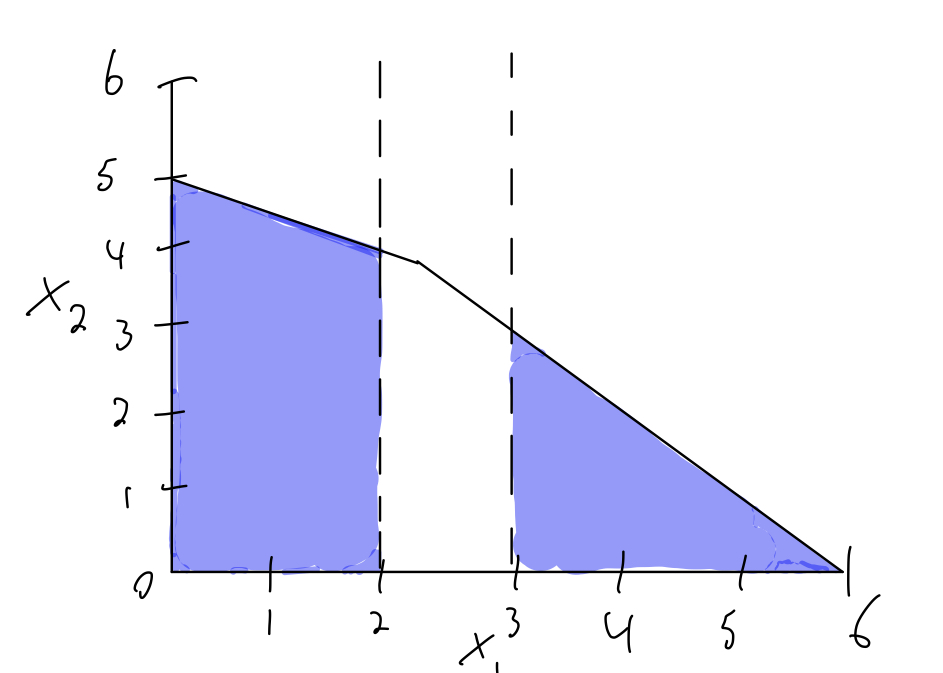

Run the following cell to see if the picture you drew in **Q34** was correct.

In [54]:
nodes[1].show()

The outline of the original LP relaxation is still shown on the left. Now that we have eliminated some of the fractional feasible solutions, we now have 2 feasible regions to consider. The darker one is the feasible region associated with the current node which is also shaded darker in the branch and bound tree. The unexplored nodes in the branch and bound tree are not shaded in.

**Q35:** Which feasible solutions to the LP relaxation are removed by this branch?

**A:** All linear feasible solutions between x1=2 and x1=3

**Q36:** At the current (dark) node, what constraints will we add? How many feasible regions will the original LP relaxation be broken into?

**A:** We will add x2<=3 to one of the resulting nodes and then x2>=4 to the other resulting node.

In [55]:
nodes[2].show()

**Q37:** What is the optimal solution at the current (dark) node? Do we have to further explore this branch? Explain.

**A:** The optimal solution is (2,3) and the optimal value is 34.

**Q38:** Recall shaded nodes have been explored and the node shaded darker (and feasible region shaded darker) correspond to the current node and its feasible region. Nodes not shaded have not been explored. How many nodes have not yet been explored?

Two nodes in our current branch have not been explored.

**Q39:** How many nodes have a degree of one in the branch and bound tree? (That is, they are only connected to one edge). These nodes are called leaf nodes. What is the relationship between the leaf nodes and the remaining feasible region?

**A:** Three nodes have a degree of one. Leaf nodes are the integers near the edges of the feasible solution area and are on the edges of the integer solution points.

In [56]:
# Show the next two iterations of the branch and bound algorithm
nodes[3].show()
nodes[4].show()

**Q40:** At the current (dark) node, we added the constraint $x_1 \leq 1$. Why were the fractional solutions $1 < x_1 < 2$ not eliminated for $x_2 <= 3$?

**A:** Looking at the graph, we can see that while the constraint x2<=3 is a cutting plane, it does not cut off the points between 1 and 2 for x1. Or at least not all of the points. It does cut off some but not all so it cannot be eliminated.

In [57]:
# Show the next three iterations of the branch and bound algorithm
nodes[5].show()
nodes[6].show()
nodes[7].show()

**Q41:** What constraints are enforced at the current (dark) node? Why are there no feasible solutions at this node?

**A:** The current constraints are: x1<=2, x2>=4, and x1>=2. This means that x1 = 2 and when x1 = 2, it is impossible for x2 to be >=4.

In [58]:
nodes[8].show()

**Q42:** Are we done? If so, what nodes are fathomed and what is the optimal solution? Explain.

**A:** All nodes that are are leaf nodes are fathomed as they all have integer inputs. The optimal solution is (3,3) which has an optimal value of 39.

Let's look at branch and bound visualization for an integer program with 3 decision variables!

In [59]:
nodes = gilp.bnb_visual(gilp.examples.VARIED_BRANCHING_3D_IP)

In [60]:
# Look at the first 3 iterations
nodes[0].show()
nodes[1].show()
nodes[2].show()

Let's fast-forward to the final iteration of the branch and bound algorithm.

In [61]:
nodes[-1].show()

**Q43:** Consider the feasible region that looks like a rectangular box with one corner point at the origin. What node does it correspond to in the tree? What is the optimal solution at that node?

**A:** The corner point corresponds to the fathom nodes. The optimal solution at the optimal node is (0,3,1) which has an optimal solution of 13.

**Q44:** How many branch and bound nodes did we explore? What was the optimal solution? How many branch and bound nodes would we have explored if we knew the value of the optimal solution before starting branch and bound?

**A:** We explored 12 branch and bound nodes not counting the original node. The optimal solution was 13 at (0,3,1). If we knew the value of the branch and bound before starting we would have explored at most two nodes.

## Bonus: Branch and Bound for Knapsack

Consider the following example:

| item | value | weight
|------|-------|-------
|  1   |   2   |   1 
|  2   |   9   |   3 
|  3   |   6   |   2 

The linear program formulation will be:


$$\begin{align*}
\max \quad & 2x_1+9x_2+6x_3\\
\text{s.t.} \quad & 1x_1+3x_2+2x_3 \leq 10 \\
& x_1, x_2, x_3 \geq 0, \quad \text{integer}
\end{align*}$$

In gilp, we can define this lp as follows:

In [ ]:
lp = gilp.LP([[1,3,2]],
             [10],
             [2,9,6])

for fig in gilp.bnb_visual(lp):
    fig.show()